In [1]:
import polars as pl
import pyarrow.dataset as ds
from pyarrow import fs
import pandas as pd
from datetime import date, timedelta

from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.metrics import mse
from darts.models import TCNModel, CatBoostModel, NBEATSModel, NLinearModel, RNNModel, ARIMA, TFTModel

from pytorch_lightning.callbacks import Callback
import torch

from pytorch_lightning.callbacks import Callback, EarlyStopping
from optuna.integration import PyTorchLightningPruningCallback
import optuna

import json

# Links

In [2]:
aquatic_link = "https://data.ecoforecast.org/neon4cast-targets/aquatics/aquatics-expanded-observations.csv.gz"
terrestrial_link = "https://data.ecoforecast.org/neon4cast-targets/terrestrial_30min/terrestrial_30min-targets.csv.gz"
tick_link = "https://data.ecoforecast.org/neon4cast-targets/ticks/ticks-targets.csv.gz"
phenology_link = "https://data.ecoforecast.org/neon4cast-targets/phenology/phenology-targets.csv.gz"
beetle_link = "https://data.ecoforecast.org/neon4cast-targets/beetles/beetles-targets.csv.gz"

# Data-processing utility functions

In [3]:
def NOAA_stage3_scan(
    site_id:str = "TREE", 
    variable:str = "TMP"
):
    s3 = fs.S3FileSystem(endpoint_override = "data.ecoforecast.org", anonymous = True)
    path = "neon4cast-drivers/noaa/gefs-v12/stage3/parquet"
    dataset = ds.dataset(path, filesystem=s3)
    return (
        pl.scan_pyarrow_dataset(dataset)
        .filter(pl.col("site_id") == site_id)
        .filter(
          (pl.col("variable") == variable)
        )
        .collect()
        # .pivot(index = "datetime", columns = "variable", values = "prediction")
    )

def day_mean(df, var_to_avg = "TMP", time_col = "datetime", avg_name = "TMP_day_avg"):
    """
    averages values of the column given over the course of a day
    """
    return (
        df
        .with_columns(pl.col(time_col).cast(pl.Date).alias("date"))
        .groupby("date")
        .agg(
            [
                pl.col(var_to_avg).mean().alias(avg_name)
            ]
        )
        .sort("date")
    )

def day_mean_several(df, var_names, time_col = "datetime", avg_name_app = "day_avg"):
    """
    averages values of the column given over the course of a day
    """
    return (
        df
        .with_columns(pl.col(time_col).cast(pl.Date).alias("date"))
        .groupby("date")
        .agg(
            [
                pl.col(var).mean().alias("_".join([var,avg_name_app])) for var in var_names
            ]
        )
        .sort("date")
    )

def pl_to_series(df, time_col = "date", freq = "D"):
    """
    input: polars dataframe
    output: corresponding darts.TimeSeries
    
    for now the easiest thing is to use pandas as a middle-man.
    """
    pd_df = df.to_pandas()
    pd_df[time_col] = pd.to_datetime(pd_df[time_col]).dt.tz_localize(None)
    return (
        TimeSeries.from_dataframe(
            pd_df,
            time_col = time_col,
            freq = freq,
        )
    )

def read_neon(
    site_id, 
    time_col = "datetime", 
    link = "https://data.ecoforecast.org/neon4cast-targets/beetles/beetles-targets.csv.gz",
):
    site_data = pd.read_csv(link)
    site_data[time_col] = pd.to_datetime(site_data["datetime"]).dt.tz_localize(None)
    return (
        site_data
        .loc[site_data["site_id"] == site_id]
    )


def inspect_variables(
    link,
    var_col_names = ["variable"],
):
    site_data = pd.read_csv(link)
    print(f"inspect_variables: FYI, the columns are {site_data.columns}")
    return (
        {
            var: f"{site_data[var].unique()}".replace("\n","") for var in var_col_names
        }
    )

In [4]:
def quick_neon_series(
    site_id,
    link = terrestrial_link,
    freq = "D",
    time_col = "datetime",
    day_avg: bool = False,
    start_date = pd.Timestamp("2020-09-25"),
):
    # pandas
    data = read_neon(
        site_id = site_id, 
        time_col = time_col, 
        link = link,
    )
    
    # polars
    data_pl = pl.from_pandas(
        data
        .pivot(index = time_col, columns = "variable", values = "observation")
        .reset_index()
    )
    
    # optional average
    if day_avg:
        freq = "D" # override user-set frequency
        data_pl = day_mean_several(
            data_pl, 
            data["variable"].unique(), 
            time_col = time_col, 
            avg_name_app = "day_avg",
        )
        time_col = "date"
    
    # darts
    data_series = fill_missing_values(
        pl_to_series(data_pl, time_col = time_col, freq = freq)
    )
    
    # split
    pre, data_series_out = data_series.split_before(start_date)
    
    return data_series_out

# Get NEON data

In [8]:
konz = quick_neon_series(
    site_id = "KONZ",
    link = terrestrial_link,
    freq = "D",
    time_col = "datetime",
    day_avg= True,
)

kona = quick_neon_series(
    site_id = "KONA",
    link = terrestrial_link,
    freq = "D",
    time_col = "datetime",
    day_avg= True,
)

# just use 'le' subseries as covariate, 'nee' is too noisy here
ukfs = quick_neon_series(
    site_id = "UKFS",
    link = terrestrial_link,
    freq = "D",
    time_col = "datetime",
    day_avg= True,
)


#### Old form

In [189]:
# terr = read_neon(
#     site_id = "WOOD", 
#     time_col = "datetime", 
#     link = terrestrial_link,
# )

# phen = read_neon(
#     site_id = "WOOD",
#     time_col = "datetime", 
#     link = phenology_link,
# )

In [188]:
# # pivot table, and have datetime column
# terr_pl = pl.from_pandas(
#     terr
#     .pivot(index = "datetime", columns = "variable", values = "observation")
#     .reset_index()
# )

# phen_pl = pl.from_pandas(
#     phen
#     .pivot(index = "datetime", columns = "variable", values = "observation")
#     .reset_index()
# )

In [190]:
# # day-average data - reduce noise and dimension
# terr_daily = day_mean_several(
#     terr_pl, 
#     ["nee", "le"], 
#     time_col = "datetime", 
#     avg_name_app = "day_avg",
# )

# phen_daily = day_mean_several(
#     phen_pl, 
#     ["gcc_90", "rcc_90"], 
#     time_col = "datetime", 
#     avg_name_app = "day_avg",
# )

In [ ]:
# phen_daily

In [193]:
# fill values
# terr_series = fill_missing_values(
#     pl_to_series(terr_daily)
# )
# phen_series = fill_missing_values(
#     pl_to_series(phen_daily)
# )

# # have dates match NOAA data
# terr_pre, terr_series = terr_series.split_before(pd.Timestamp("2020-09-25"))
# phen_pre, phen_series = phen_series.split_before(pd.Timestamp("2020-09-25"))

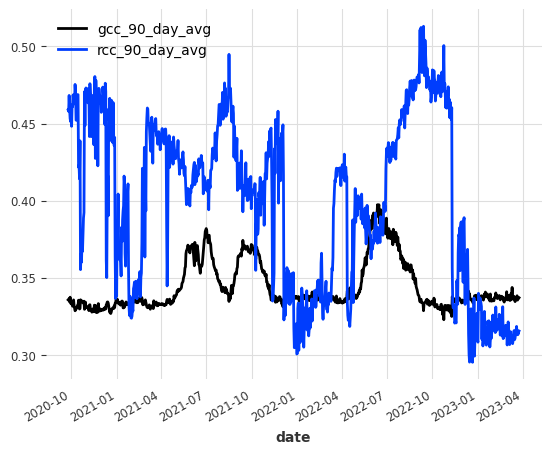

In [163]:
phen_series.plot()

# Get NOAA data

In [78]:
# df = day_mean(NOAA_stage3_scan(site_id = "WOOD", variable = "TMP"))
s3 = fs.S3FileSystem(endpoint_override = "data.ecoforecast.org", anonymous = True)
path = f"neon4cast-drivers/noaa/gefs-v12/stage3/parquet/"
dataset = ds.dataset(path, filesystem=s3, partitioning=["site_id"])

historic_noaa_full = pl.scan_pyarrow_dataset(dataset) 

# specialize to a given site, go to pivot
historic_noaa = (
    historic_noaa_full
    .filter(pl.col("site_id") == "KONZ")
    .collect()
    .pivot(index = "datetime", columns = "variable", values = "prediction")
)
# historic_noaa["datetime"] = pd.to_datetime(historic_noaa["datetime"])
# historic_noaa.with_columns(pl.col("datetime").cast(pl.Datetime).alias("datetime"))

# thin out
historic_noaa = historic_noaa[["datetime", "air_temperature", "air_pressure", "precipitation_flux", "relative_humidity"]]

# optionally day-average:

historic_noaa_daily = day_mean_several(
    historic_noaa, 
    ["air_temperature", "air_pressure", "precipitation_flux", "relative_humidity"]
)
historic_noaa_daily.columns = ["date", "tmp_avg", "pressure_avg", "precip_flux_avg", "rel_humidity_avg"]

In [79]:
noaa_covariates = pl_to_series(historic_noaa_daily, time_col = "date", freq = "D")
noaa_covariates = fill_missing_values(noaa_covariates)

In [14]:
# noaa_covariates.head()

# Cutting and boxing covariates

In [80]:
# Dividing into "past" and "future" setting myself at date_cutoff POV

date_cutoff = pd.Timestamp("2023-02-20")
past_noaa, future_noaa = noaa_covariates.split_before(date_cutoff)
train_konz, val_konz = konz.split_before(date_cutoff)
train_kona, val_kona = kona.split_before(date_cutoff)
train_ukfs, val_ukfs = ukfs.split_before(date_cutoff)

In [81]:
# # squish together different combinations to use as covariates

covariates_konz = (
    past_noaa
    .concatenate(train_kona, axis = "component")
    .concatenate(train_ukfs[['le_day_avg']], axis = "component")
)


In [22]:
# covariates_konz.columns

# Fit Models

#### **ARIMA**

In [152]:
add_encoders={
    'cyclic': {'future': ['month']},
}

arima = ARIMA(
    p = 100,
    d = 2,
    q = 1,
    add_encoders = add_encoders
)

In [154]:
# arima.fit(
#     train_terr[['le_day_avg']], 
#     future_covariates = noaa_covariates
# )

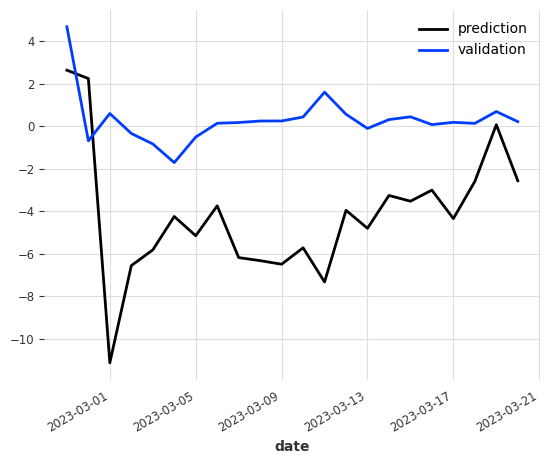

In [65]:
arima.predict(len(val_terr), future_covariates = future_noaa).plot(label = "prediction")
val_terr["le_day_avg"].plot(label = "validation")

#### **N-Linear**

In [36]:
callbacks = [EarlyStopping("train_loss", min_delta=0.00001, patience=200, verbose=True)]
pl_trainer_kwargs = {
    "accelerator": "gpu", 
    "devices": [1], 
    "callbacks": callbacks,
} 
# pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "devices": [0],
#             "callbacks": callbacks,
#         }
num_workers = 4
add_encoders={
    'cyclic': {'future': ['month']},
}

In [82]:
# Terrestrial

nlinear = NLinearModel(
    input_chunk_length = 356,
    output_chunk_length = 30,
    pl_trainer_kwargs = pl_trainer_kwargs,
    add_encoders = add_encoders,
    optimizer_kwargs = {'lr':0.00001}
)

nlinear.fit(
    series = train_konz,
    past_covariates = covariates_konz,
    epochs = 300,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type             | Params
----------------------------------------------------
0 | criterion      | MSELoss          | 0     
1 | train_metrics  | MetricCollection | 0     
2 | val_metrics    | MetricCollection | 0     
3 | layer          | Linear           | 235 K 
4 | linear_fut_cov | Linear           | 6     
----------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.940     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 200 records. Best score: 10.394. Signaling Trainer to stop.


In [83]:
forecast = nlinear.predict(len(val_konz))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

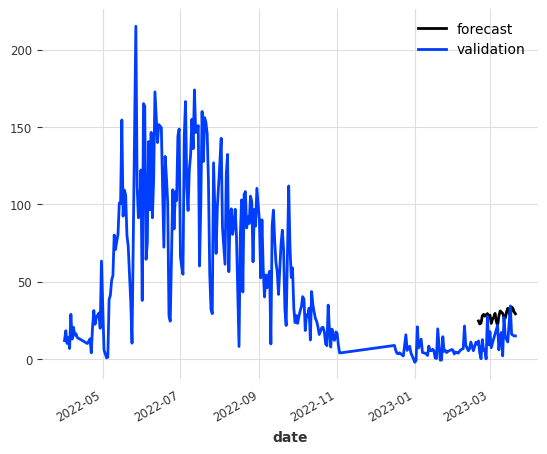

In [84]:
forecast['le_day_avg'].plot(label = "forecast")
konz_pre, konz_plt = konz.split_before(pd.Timestamp("2022-04-01"))
konz_plt['le_day_avg'].plot(label = "validation")

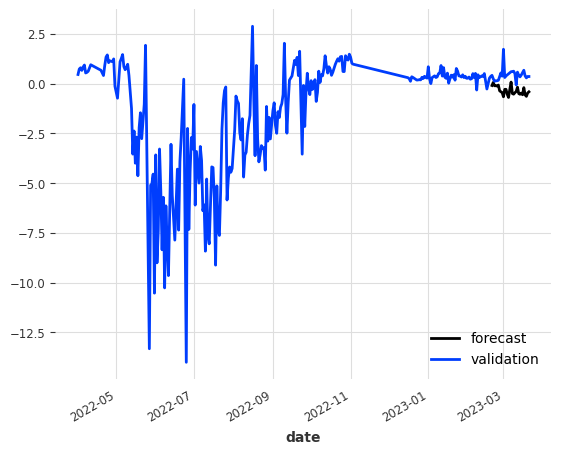

In [85]:
forecast['nee_day_avg'].plot(label = "forecast")
konz_plt['nee_day_avg'].plot(label = "validation")

#### **RNNModel**

In [86]:
callbacks = [EarlyStopping("train_loss", min_delta=0.00001, patience=10, verbose=True)]
pl_trainer_kwargs = {
    "accelerator": "gpu", 
    "devices": [1], 
    "callbacks": callbacks,
} 
# pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "devices": [0],
#             "callbacks": callbacks,
#         }
num_workers = 4
add_encoders={
    'cyclic': {'future': ['month']},
}

In [87]:
rnn = RNNModel(
    input_chunk_length = 356,
    n_rnn_layers = 10,
    dropout = 0.3,
    training_length = 450,
    pl_trainer_kwargs = pl_trainer_kwargs,
    add_encoders = add_encoders,
    optimizer_kwargs = {'lr':0.0005}
)

rnn.fit(
    series = train_konz,
    future_covariates = covariates_konz,
    epochs = 300,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 12.7 K
4 | V             | Linear           | 52    
---------------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 1401.069
Monitored metric train_loss did not improve in the last 10 records. Best score: 1401.069. Signaling Trainer to stop.


#### **NBeats**

In [88]:
callbacks = [EarlyStopping("train_loss", min_delta=0.00001, patience=200, verbose=True)]
pl_trainer_kwargs = {
            "accelerator": "gpu",
            "devices": [0],
            "callbacks": callbacks,
        }
num_workers = 4

nbeats = NBEATSModel(
    input_chunk_length = 356,
    output_chunk_length = 40,
    pl_trainer_kwargs = pl_trainer_kwargs,
    add_encoders = add_encoders,
    optimizer_kwargs = {'lr':0.001}
)

In [90]:
nbeats.fit(
    series = train_konz,
    past_covariates = covariates_konz,
    epochs = 300,
)

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = NBEATSModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | sta

Training: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 200 records. Best score: 244.993. Signaling Trainer to stop.


In [91]:
forecast = nbeats.predict(len(val_konz))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

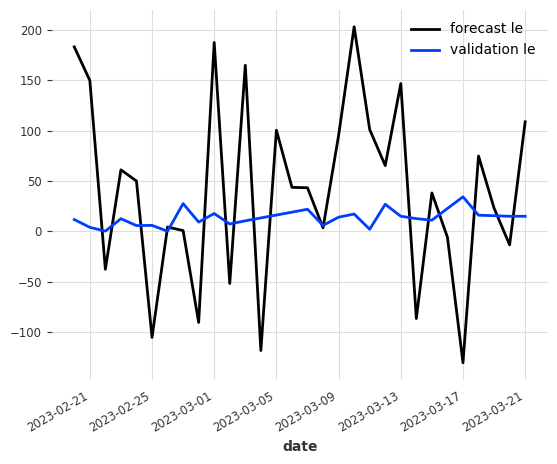

In [92]:
forecast["le_day_avg"].plot(label = "forecast le")
val_konz["le_day_avg"].plot(label = "validation le")

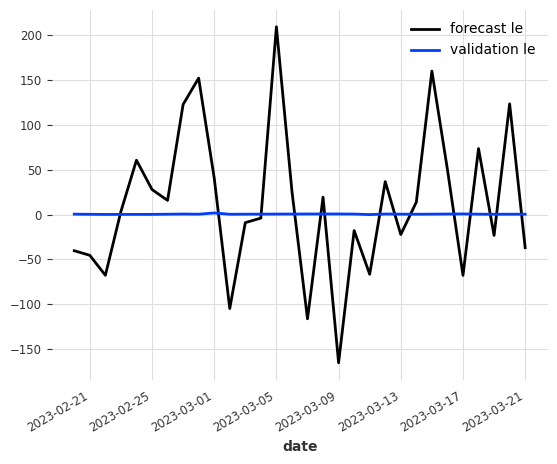

In [93]:
forecast["nee_day_avg"].plot(label = "forecast le")
val_konz["nee_day_avg"].plot(label = "validation le")

#### **TFT**

In [94]:
callbacks = [EarlyStopping("train_loss", min_delta=0.00001, patience=200, verbose=True)]
pl_trainer_kwargs = {
            "accelerator": "gpu",
            "devices": [1],
            "callbacks": callbacks,
        }
num_workers = 4

tft = TFTModel(
    input_chunk_length = 356,
    output_chunk_length = 60,
    pl_trainer_kwargs = pl_trainer_kwargs,
    add_encoders = add_encoders,
    optimizer_kwargs = {'lr':0.001}
)

In [95]:
tft.fit(
    series = train_konz,
    past_covariates = covariates_konz,
    epochs = 400,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 7.4 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.2 K 
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedRes

Training: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 127.196
Metric train_loss improved by 9.981 >= min_delta = 1e-05. New best score: 117.215
Metric train_loss improved by 42.149 >= min_delta = 1e-05. New best score: 75.066
Metric train_loss improved by 11.341 >= min_delta = 1e-05. New best score: 63.725
Metric train_loss improved by 15.558 >= min_delta = 1e-05. New best score: 48.167
Metric train_loss improved by 0.044 >= min_delta = 1e-05. New best score: 48.124
Metric train_loss improved by 18.233 >= min_delta = 1e-05. New best score: 29.891
Metric train_loss improved by 5.148 >= min_delta = 1e-05. New best score: 24.743
Metric train_loss improved by 0.221 >= min_delta = 1e-05. New best score: 24.521
Metric train_loss improved by 0.387 >= min_delta = 1e-05. New best score: 24.135
Metric train_loss improved by 11.380 >= min_delta = 1e-05. New best score: 12.754
Metric train_loss improved by 0.391 >= min_delta = 1e-05. New best score: 12.363
Metric train_loss improved by 4.493 >= min_delta = 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

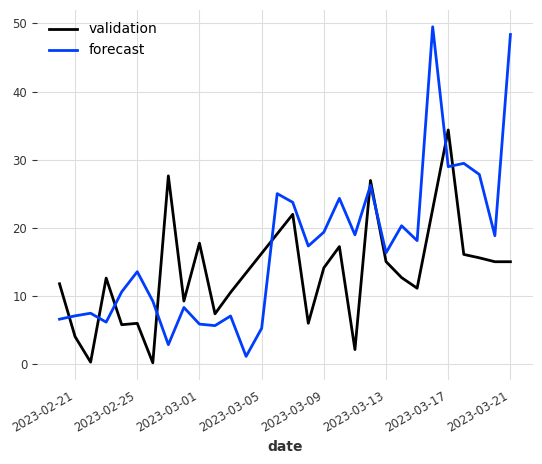

In [96]:
konz_pre, konz_plt = konz.split_before(pd.Timestamp("2022-04-01"))
# konz_plt['le_day_avg'].plot(label = "validation")
val_konz['le_day_avg'].plot(label = "validation")
forecast = tft.predict(len(val_konz))
forecast['le_day_avg'].plot(label = "forecast")

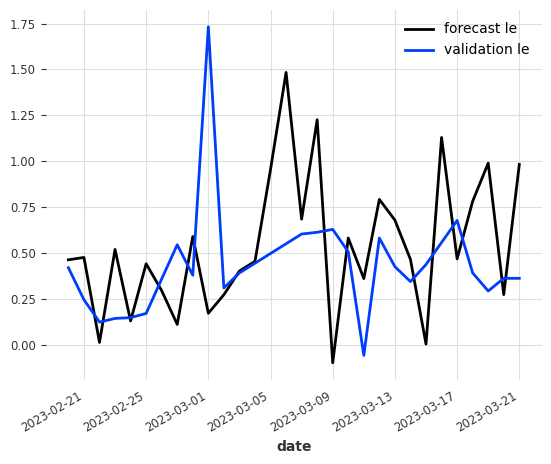

In [98]:
forecast["nee_day_avg"].plot(label = "forecast le")
val_konz["nee_day_avg"].plot(label = "validation le")

# Tuned models

### TFT

In [100]:
callbacks = [EarlyStopping("train_loss", min_delta=0.00001, patience=200, verbose=True)]
pl_trainer_kwargs = {
            "accelerator": "gpu",
            "devices": [1],
            "callbacks": callbacks,
        }
num_workers = 4

tft = TFTModel(
    input_chunk_length = 356,
    output_chunk_length = 48,
    hidden_size = 16,
    lstm_layers = 2,
    num_attention_heads = 3,
    hidden_continuous_size = 9,
    dropout = 0.3903703442922965,
    pl_trainer_kwargs = pl_trainer_kwargs,
    add_encoders = add_encoders,
    optimizer_kwargs = {'lr':0.004907493473804092}
)

In [101]:
tft.fit(
    series = train_konz,
    past_covariates = covariates_konz,
    epochs = 400,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.3 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.3 K 
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedRes

Training: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 143.829
Metric train_loss improved by 34.241 >= min_delta = 1e-05. New best score: 109.588
Metric train_loss improved by 29.348 >= min_delta = 1e-05. New best score: 80.239
Metric train_loss improved by 6.704 >= min_delta = 1e-05. New best score: 73.536
Metric train_loss improved by 4.353 >= min_delta = 1e-05. New best score: 69.183
Metric train_loss improved by 48.867 >= min_delta = 1e-05. New best score: 20.316
Metric train_loss improved by 0.886 >= min_delta = 1e-05. New best score: 19.430
Metric train_loss improved by 0.446 >= min_delta = 1e-05. New best score: 18.984
Metric train_loss improved by 2.596 >= min_delta = 1e-05. New best score: 16.387
Metric train_loss improved by 0.253 >= min_delta = 1e-05. New best score: 16.134
Metric train_loss improved by 3.203 >= min_delta = 1e-05. New best score: 12.931
`Trainer.fit` stopped: `max_epochs=400` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

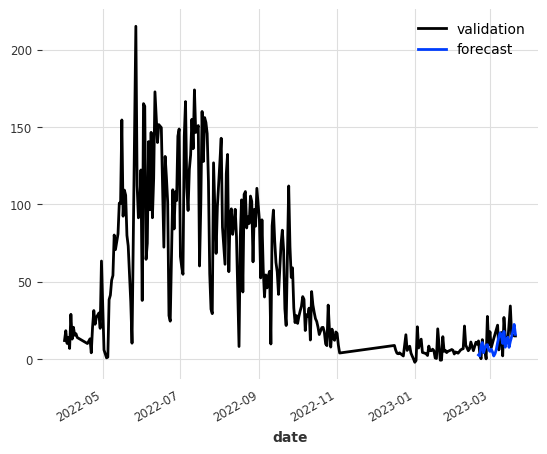

In [103]:
konz_pre, konz_plt = konz.split_before(pd.Timestamp("2022-04-01"))
# konz_plt['le_day_avg'].plot(label = "validation")
konz_plt['le_day_avg'].plot(label = "validation")
forecast = tft.predict(len(val_konz))
forecast['le_day_avg'].plot(label = "forecast")

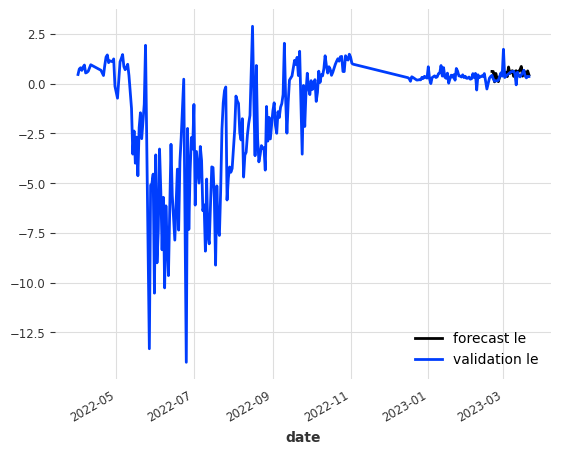

In [104]:
forecast["nee_day_avg"].plot(label = "forecast le")
konz_plt["nee_day_avg"].plot(label = "validation le")

### Random Forest

In [105]:
from darts.models import RandomForest

rf = RandomForest(
    output_chunk_length = 32,
    lags=78,
    lags_past_covariates=64,
    n_estimators=116,
    max_depth=9,
)

In [107]:
rf.fit(
    series = train_konz,
    past_covariates = covariates_konz,
)

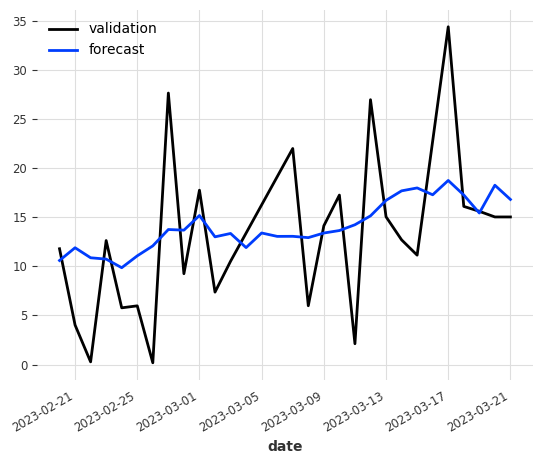

In [109]:
konz_pre, konz_plt = konz.split_before(pd.Timestamp("2022-04-01"))
# konz_plt['le_day_avg'].plot(label = "validation")
val_konz['le_day_avg'].plot(label = "validation")
forecast = rf.predict(len(val_konz))
forecast['le_day_avg'].plot(label = "forecast")

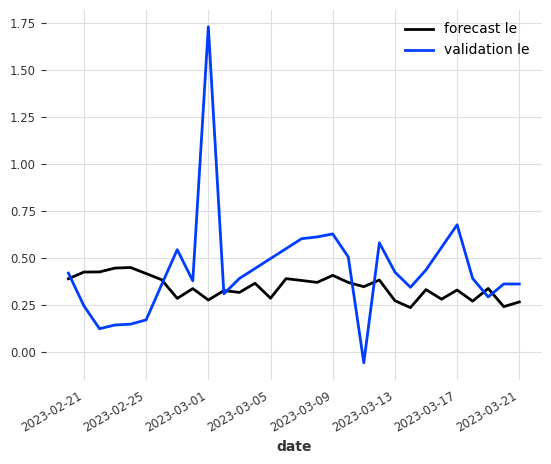

In [111]:
forecast["nee_day_avg"].plot(label = "forecast le")
# konz_plt["nee_day_avg"].plot(label = "validation le")
val_konz["nee_day_avg"].plot(label = "validation le")